### Tính vi phân tự động

- Vi phân là phép tính thiết yếu trong hầu như tất cả thuật toán học sâu. Mặc dù các phép toán khá trực quan nhưng với các mô hình phức tạp thì việc tự tính rõ ràng rất dễ sai.
- Gói thư viện autograd giải quyết vấn đề này một cách nhanh chóng và hiệu quả bằng cách tự động hóa các phép dịch đạo hàm.
- Khi đưa dữ liệu chạy qua mô hình, autograd xây dựng một đồ thị và theo dõi xem dữ liệu nào kết hợp với các phép tính nào để tạo ra kết quả. Với đồ thị này autograd sau đó có thể lan truyền ngược gradient lại theo ý muốn.
- Lan truyền ngược ở đây chỉ là truy ngược lại đồ thị tính toán và điền vào đó các giá trị đạo hàm riêng theo từng tham số.

In [18]:
from mxnet import autograd, np, npx
from d2l import mxnet as d2l
from IPython import display
npx.set_np()

x = np.arange(4)
x

array([0., 1., 2., 3.])

Lấy ví dụ ta cần tính vi phân của hàm số u = 2xT * x theo vector cột x.
## Lưu ý
1. Trước khi có thể tính gradient của y theo x ta cần nơi lưu trữ, và KHÔNG được cấp phát thêm bộ nhớ mỗi khi tính đạo hàm theo một biến xác định vì ta thường cập nhật cùng một tham số hàng vạn lần và sẽ nhanh chóng hết bộ nhớ.
2. Bản thân giá trị gradient theo vector x cũng là một vector với cùng kích thước. Do vậy trong mã nguồn sẽ trực quan hơn nếu ta lưu giá trị gradient tính theo x dưới dạng một thuộc tính của ndarray. Ta cấp bộ nhớ cho gradient của một ndarray bằng cách gọi phương thức attach_grad

In [19]:
x.attach_grad()

Sau khi tính toán gradient theo biến x, ta có thể truy cập nó thông qua thuộc tính grad. Để an toàn, x.grad được khởi tạo là một mảng chứa các giá trị 0. 
Điều này hợp lý vì trong học sâu, lấy gradient thường là để cập nhật các tham số bằng cách cộng hoặc trừ gradient để cực đại hoặc cực tiểu hóa hàm đó. Bằng cách khởi tạo gradent bằng mảng chứa giá trị 0, ta đảm bảo rằng bất kỳ cập nhật vô tình nào trước khi gradient được tính toán sẽ không làm thay đổi các giá trị của các tham số.

In [20]:
x.grad

array([0., 0., 0., 0.])

MXNet sẽ bật một thiết bị ghi hình để ghi lại đường đi của mỗi biến được tạo, và điều này chỉ xảy ra khi được ra lệnh rõ ràng.

In [21]:
with autograd.record():
    y = 2 * np.dot(x, x)
y

array(28.)

Do x là một ndarray có độ dài bằng 4, np.dot sẽ tính toán tích vô hướng của x và x, trả về một số vô hướng rồi gán cho y. Tiếp theo, ta sẽ tính toán gradient của y theo mỗi thành phần của x một cách tự động bằng cách gọi hàm backward của y.

In [22]:
y.backward()

Khi kiểm tra lại giá trị của x.grad, ta sẽ thấy nó được ghi đè bằng gradient mới được tính toán

In [23]:


x.grad

array([ 0.,  4.,  8., 12.])

Gradient tương ứng của hàm y = 2 * Transpose(x) * x là 4x.

In [24]:
x.grad == 4 * x

array([ True,  True,  True,  True])

Nếu ta tiếp tục tính gradient của một biến khác mà giá trị của nó là kết quả theo biến x thì nội dung trong x.grad sẽ bị ghi đè.

In [25]:
with autograd.record():
    y = x.sum()
y.backward()
x.grad

array([1., 1., 1., 1.])

### Truyền ngược cho các biến không phải số vô hướng
- Khi y không phải số vô hướng thì vi phân của một vector y theo vector x là một ma trận.
- Tuy nhiên, khi đối tượng này xuất hiện trong học sâu thì khi gọi làn truyền ngược trên một vector, ta đang tính toán hàm mất mát theo mỗi batch bao gồm một vài mẫu huấn luyện. Ở đây, ý định của ta không phải là tính toán ma trận vi phân mà là tính tổng của các đạo hàm riêng được tính toán độc lập cho mỗi mẫu trong batch,
- Vì vậy, khi ta gọi backward lên một biến vector y - là một hàm của x, MXNet sẽ cho rằng ta muốn tính tổng của gradient. Tức là MXNet sẽ tạo một biến mới có giá trị là số vô hướng bằng cách cộng lại các phần tử trong y và tính gradient theo x của biến mới này.

In [26]:
with autograd.record():
    y = x * x # Y là một vector có số dạng tương tự với X
y.backward()

u = x.copy()
u.attach_grad()

with autograd.record():
    v = (u * u).sum() # V là một biến vô hướng, V = Y.sum()
v.backward()

x.grad == u.grad

array([ True,  True,  True,  True])

### Tách rời tính toán
- Đôi khi chúng ta muốn chuyển một số phép tính ra khỏi đồ thị tính toán. Ví dụ, giả sử y đã được tính như một hàm của x, rồi sau đó z được tính như một hàm của cả y và x. Bây giờ, giả sử ta muốn tính gradient của z theo x, nhưng vì lý do nào đó ta lại muốn xem như y là một hằng số và chỉ xét đến vai trò của x như là biến số của z sau khi giá trị của y đã được tính.
- Trong trường hợp này, ta có thể gọi u = y.detach() để trả về biến u mới có cùng có giá trị như y nhưng không còn chứa các thông tin về cách mà y đã đượch tính trong đồ thị tính toán. Bằng cách này, ta đã tính u như một hàm của x ở ngoài phạm vi của x ở ngoài phạm vi của autograd. Chính vì vậy, hàm backward sau đây sẽ tính đạo hàm riêng của z = u * x theo x khi xem u như là một hằng số, thay vì đạo hàm riêng của z = x * x * x theo x

In [27]:
with autograd.record():
    y = x * x;
    u = y.detach()
    z = u * x;
z.backward()
x.grad == u

array([ True,  True,  True,  True])

Bởi sự tính toán của y đã được ghi lại, chúng ta có thể gọi y.backward() sau đó để lấy đạo hàm của y = x * x, tức là 2 * x

In [28]:
y.backward()
x.grad == 2 * x

array([ True,  True,  True,  True])

Lưu ý rằng khi ta gắn gradient vào một biến x, x = x.detach() sẽ được gọi ngầm. Nếu x được tính dựa trên các biến khác, phần tính toán này sẽ không được sử dụng trong hàm backward

In [29]:
y = np.ones(4) * 2
y.attach_grad()

with autograd.record():
    u = x * y
    u.attach_grad() # Tự động chạy u = u.detach(), đạo hàm của z theo y bằng 0, đạo hàm của z theo x = -1
    # Do u đã được chạy cấp phát bộ nhớ cho gradient nên giờ u được coi như là một biến, những phép tính tạo ra u không ảnh hướng
    # và đạo hàm của z theo u bằng 5
    z = 5 * u - x
z.backward()
x.grad, y.grad, u.grad

(array([-1., -1., -1., -1.]), array([0., 0., 0., 0.]), array([5., 5., 5., 5.]))

### Tính gradient của luồng điều khiển Python

- Một lợi thế của việc sử dụng vi phân tự động là khi việc xây dựng đồ thị tính toán đòi hỏi trải qua một loạt các câu leenmhj điều khiển luồng Python ví dụ như câu lệnh điều kiện, vòng lặp và các lệnh gọi hàm tùy ý, ta vẫn có thể tính gradient của biến kết quả. 
- Trong đoạn mã sau, lưu ý rằng số lần lặp của vòng while và kết quả của lệnh if đều phụ thuộc vào giá trị của đầu vào a.

In [30]:
def f(a):
    b = a * 2
    while np.linalg.norm(b) < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [31]:
a = np.random.normal()
a.attach_grad()
with autograd.record():
    d = f(a)
d.backward()

Giờ ta có thể phân tích hàm f được định nghĩa ở phía trên. Hãy để ý rằng hàm này tuyến tính từng khúc theo đầu vào a. Nói cách khác, với mọi giá trị của a tồn tại một hằng số k sao cho f(a) = k * a, ở đó giá trị của k phụ thuộc vào đầu vào a. Do đó, ta có thể kiểm tra giá trị của gradient bằng cách tính d / a.

In [32]:
a.grad == d / a

array(True)

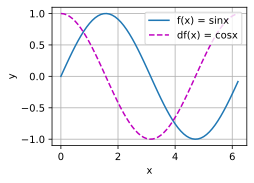

In [ ]:
def g(x):
    return np.sin(x)

x = np.arange(0, 2 * np.pi, 0.1)
x.attach_grad()
with autograd.record():
    y = g(x)

y.backward()


d2l.plot(x, [y.asnumpy(), x.grad.asnumpy()], 'x', 'y', legend = ['f(x) = sinx', 'df(x) = cosx'])